# Import

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import category_encoders as ce
import sweetviz as sv

from IPython.core.display import HTML

# Def Function

In [85]:
def rename_columns(df):
    # Convert column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Rename specific columns
    df = df.rename(columns={
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1':
        'naive_bayes_classifier_mon_1',
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2':
        'naive_bayes_classifier_mon_2'
    })

    return df

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 20
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    


In [53]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [26]:
sns.set(style='whitegrid')

# Data Preprocessing

In [94]:
df = pd.read_csv('Data/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [72]:
df.shape

(10127, 23)

In [102]:
df.dtypes

clientnum                         int64
attrition_flag                   object
customer_age                      int64
gender                           object
dependent_count                   int64
education_level                  object
marital_status                   object
income_category                  object
card_category                    object
months_on_book                    int64
total_relationship_count          int64
months_inactive_12_mon            int64
contacts_count_12_mon             int64
credit_limit                    float64
total_revolving_bal               int64
avg_open_to_buy                 float64
total_amt_chng_q4_q1            float64
total_trans_amt                   int64
total_trans_ct                    int64
total_ct_chng_q4_q1             float64
avg_utilization_ratio           float64
naive_bayes_classifier_mon_1    float64
naive_bayes_classifier_mon_2    float64
dtype: object

In [101]:
df.isna().sum()

clientnum                       0
attrition_flag                  0
customer_age                    0
gender                          0
dependent_count                 0
education_level                 0
marital_status                  0
income_category                 0
card_category                   0
months_on_book                  0
total_relationship_count        0
months_inactive_12_mon          0
contacts_count_12_mon           0
credit_limit                    0
total_revolving_bal             0
avg_open_to_buy                 0
total_amt_chng_q4_q1            0
total_trans_amt                 0
total_trans_ct                  0
total_ct_chng_q4_q1             0
avg_utilization_ratio           0
naive_bayes_classifier_mon_1    0
naive_bayes_classifier_mon_2    0
dtype: int64

In [96]:
df = rename_columns(df)

In [97]:
df.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_mon_1,naive_bayes_classifier_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# Feature Engineering

# EDA

In [108]:
sv.analyze(df).show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [100]:
df.describe()

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_mon_1,naive_bayes_classifier_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


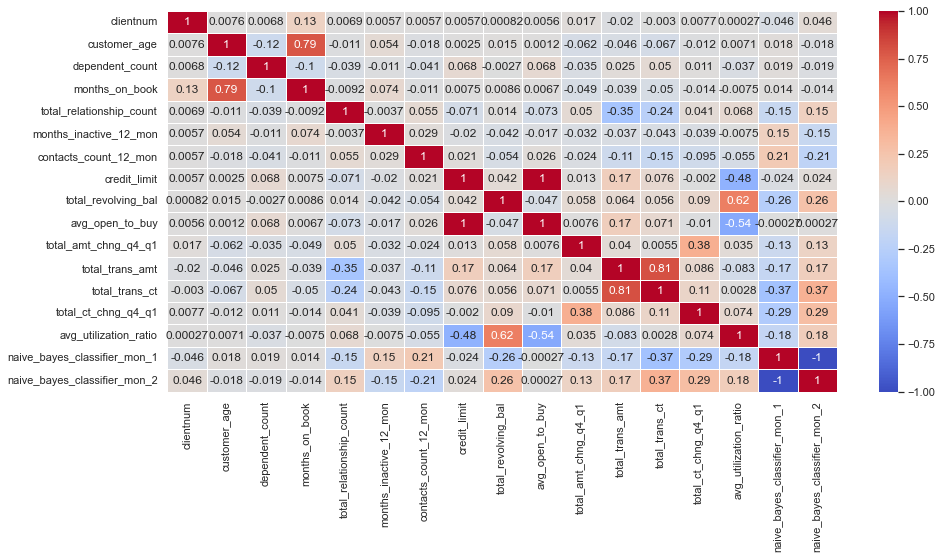

In [99]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5);

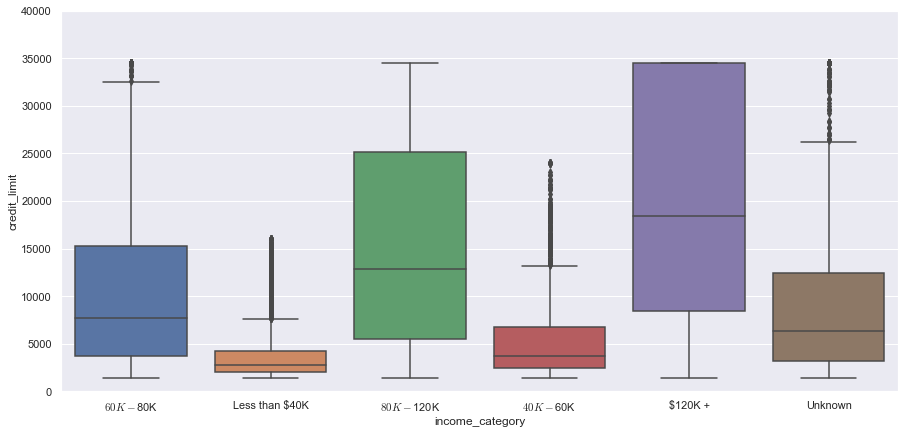

In [107]:
sns.boxplot(x=df.income_category, y=df.credit_limit)
plt.ylim(0,40000);

# Model

# Metrics Comprehension